# Ray et al 2013 Extract-Transform-Load
**Authorship:**
Adam Klie, *08/11/2022*
***
**Description:**
Notebook to extract, transform, and load (ETL) data from the Ray et al (2013) dataset.
***

In [2]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import eugene as eu
eu.settings.dataset_dir = "../../../_datasets"

Global seed set to 13
2022-09-04 19:48:01.824904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-04 19:48:01.824953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/workspaces/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/workspaces/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of N

# Download and load in the dataset to a raw `SeqData` object

In [3]:
# Load in the downloaded data, or download it if it's not there
sdata_raw = eu.datasets.ray13()

Dataset ray13 norm_data.txt.gz has already been dowloaded.


In [4]:
# Subset to set type (A or B)
sdata_setA_raw = sdata_raw[sdata_raw.seqs_annot["Probe_Set"] == "SetA"]
sdata_setB_raw = sdata_raw[sdata_raw.seqs_annot["Probe_Set"] == "SetB"]

In [5]:
# Save raw versions of these three
sdata_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_raw.h5sd"))
sdata_setA_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_raw.h5sd"))
sdata_setB_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_raw.h5sd"))

# Preprocess the training set

## Preprocess the seqs
- Padded elements of sequences are replaced with a one hot encoded value of 0.25 spanning each base.

In [6]:
eu.pp.one_hot_encode_data(sdata_setA_raw, alphabet="RNA", seq_align="center", fill_value=0.25)
eu.pp.one_hot_encode_data(sdata_setB_raw, alphabet="RNA", seq_align="center", fill_value=0.25)

One-hot-encoding sequences:   0%|          | 0/120326 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 120326 ohe_seqs added


One-hot-encoding sequences:   0%|          | 0/121031 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 121031 ohe_seqs added


## Preprocess the targets
- The values of probe intensities are clamped at 99.95% percentile per binding protein to eliminate outliers and balance the data.
- The probe intensities are normalized to a mean of 0 and a standard deviation of 1.

In [7]:
# Get a list of only the target columns
target_mask = sdata_setA_raw.seqs_annot.columns.str.contains("RNCMPT")
target_cols = sdata_setA_raw.seqs_annot.columns[target_mask]
random_cols = np.random.choice(target_cols, 9)
len(target_cols)

244

In [8]:
# Split only those training sequences in SetA into train and validation sets
eu.pp.train_test_split_data(sdata_setA_raw, train_key="train_val", split=0.8)

SeqData object modified:
    seqs_annot:
        + train_val


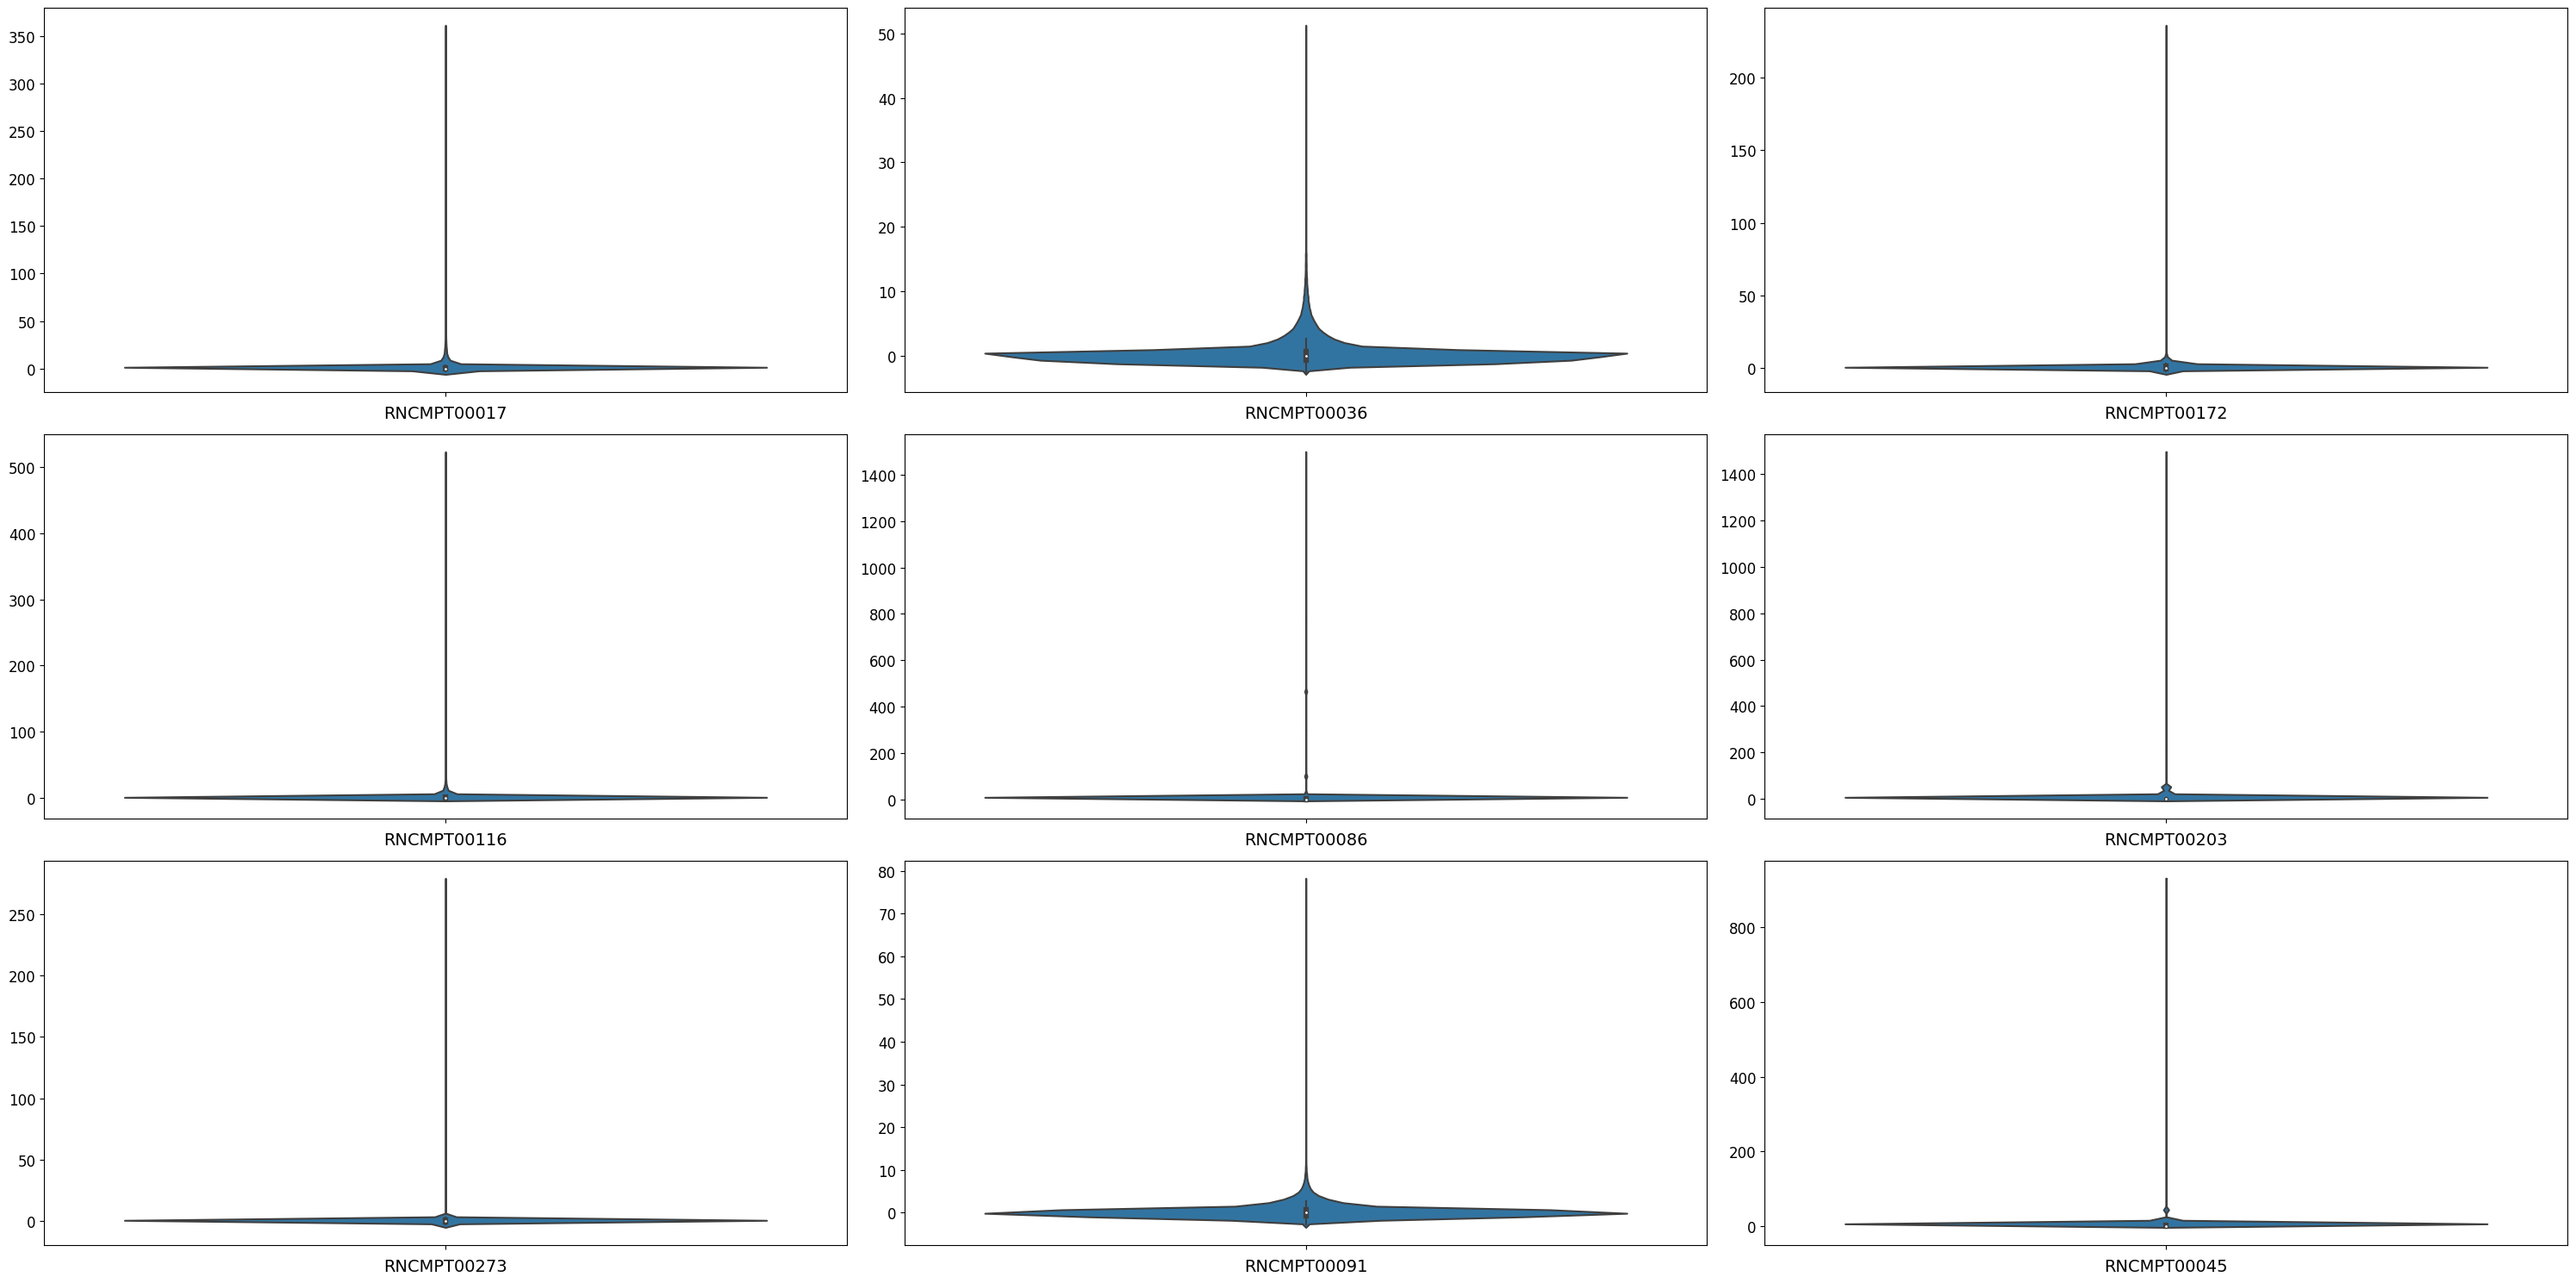

In [9]:
# Plot the distribution of the targets
eu.pl.violinplot(
    sdata_setA_raw, 
    keys=random_cols
)

In [10]:
# Clamp the targets based on percentiles
eu.pp.clamp_percentiles(sdata_setA_raw, percentile=0.9995, target_list=target_cols, train_key="train_val", store_clamp_nums=True)

In [11]:
# Check the distribution of the clamped targets
sdata_setA_raw.seqs_annot[random_cols].describe()

,RNCMPT00017,RNCMPT00036,RNCMPT00172,RNCMPT00116,RNCMPT00086,RNCMPT00203,RNCMPT00273,RNCMPT00091,RNCMPT00045
count,119693.000000,119700.000000,119711.000000,120281.000000,119713.000000,120285.000000,120291.000000,119649.000000,119685.000000
mean,0.626791,0.337392,0.238678,1.005501,0.450073,0.110447,0.167610,0.189530,0.160327
std,3.841644,1.929847,1.410418,5.192020,1.591121,1.362035,1.152793,1.489955,1.173845
min,-5.257271,-2.560690,-4.265759,-3.550487,-5.731347,-7.625524,-4.755611,-3.151492,-3.628755
25%,-0.582164,-0.717381,-0.614478,-0.521438,-0.469133,-0.608104,-0.587845,-0.696813,-0.614065
50%,0.001727,-0.001149,-0.003081,-0.006588,-0.000495,0.000189,-0.003032,-0.005053,-0.004045
75%,0.832880,0.632859,0.754474,0.893642,1.094173,0.759369,0.784946,0.649021,0.762665
max,76.807410,20.799692,14.265753,114.356463,10.868417,12.549405,16.159195,13.841901,12.016955


In [12]:
# Make sure they match up with stored values
sdata_setA_raw.uns["clamp_nums"][random_cols]

RNCMPT00017     76.807410
RNCMPT00036     20.799692
RNCMPT00172     14.265753
RNCMPT00116    114.356463
RNCMPT00086     10.868417
RNCMPT00203     12.549405
RNCMPT00273     16.159195
RNCMPT00091     13.841901
RNCMPT00045     12.016955
Name: 0.9995, dtype: float64

In [13]:
# Plot the distribution of the clamped targets
eu.pl.violinplot(
    sdata_setA_raw, 
    keys=random_cols
)

In [14]:
# Scale the targets have mean 0 and variance 1
eu.pp.scale_targets(sdata_setA_raw, targets=target_cols, train_key="train_val", suffix=False, store_scaler=True)

In [15]:
# Check the distribution of the scaled targets, should be approximately normal but not exactly
sdata_setA_raw.seqs_annot[target_cols].describe()

,RNCMPT00100,RNCMPT00101,RNCMPT00102,RNCMPT00103,RNCMPT00104,RNCMPT00105,RNCMPT00106,RNCMPT00107,RNCMPT00108,RNCMPT00109,...,RNCMPT00008,RNCMPT00090,RNCMPT00091,RNCMPT00093,RNCMPT00094,RNCMPT00095,RNCMPT00096,RNCMPT00097,RNCMPT00099,RNCMPT00009
count,120252.000000,120262.000000,120285.000000,120313.000000,120313.000000,120179.000000,120279.000000,120316.000000,120304.000000,120304.000000,...,79089.000000,120324.000000,119649.000000,120326.000000,120254.000000,120213.000000,120319.000000,118832.000000,120168.000000,74561.000000
mean,-0.000892,0.001110,-0.000894,-0.001209,-0.000981,-0.000830,0.000346,0.000853,0.002044,0.001766,...,0.000686,-0.000100,0.000048,-0.002575,-0.001236,-0.000512,-0.001675,-0.001018,-0.000980,0.003283
std,0.997410,1.020525,1.002307,0.978627,0.982749,0.998109,1.000649,1.005483,1.010201,1.009679,...,1.000385,1.001129,1.002171,0.983708,0.994508,0.986762,0.986130,0.991359,0.996083,0.998293
min,-0.708462,-0.514076,-5.600323,-1.232183,-1.532100,-4.710454,-0.407043,-0.383484,-0.450989,-0.354403,...,-2.861418,-11.530205,-2.247183,-0.734555,-2.070196,-0.839285,-0.888454,-0.709476,-1.016065,-6.098262
25%,-0.333029,-0.186311,-0.550346,-0.254521,-0.289589,-0.487386,-0.223169,-0.229103,-0.250207,-0.219683,...,-0.540149,-0.316775,-0.596122,-0.276718,-0.499617,-0.253152,-0.261539,-0.237884,-0.308991,-0.607111
50%,-0.231536,-0.131478,-0.072450,-0.058678,-0.105945,-0.167116,-0.184461,-0.192930,-0.202766,-0.182754,...,-0.160582,-0.033841,-0.130832,-0.135262,-0.143978,-0.134833,-0.115630,-0.168271,-0.174184,-0.008076
75%,-0.061493,-0.053698,0.462122,0.117865,0.142312,0.346754,-0.111788,-0.125165,-0.120029,-0.114832,...,0.328262,0.295650,0.309110,0.025993,0.271894,0.027540,0.039491,-0.044344,0.008478,0.604184
max,16.246738,24.719098,10.503280,27.510587,28.689711,9.518592,19.219405,17.907541,17.026719,19.135278,...,10.981691,15.103138,9.182879,22.778451,18.856346,29.993462,24.794541,22.160394,19.009158,5.143852


In [16]:
# Plot the distribution of the scaled targets
eu.pl.violinplot(
    sdata_setA_raw, 
    keys=random_cols
)

# Preprocess the test set
- We need to apply the clamping numbers from the training set to the test set.
- We need to apply the mean and standard deviation from the training set to the test set.

In [17]:
# Apply the same clamping to the test set
eu.pp.clamp_percentiles(sdata_setB_raw, target_list=target_cols, clamp_nums=sdata_setA_raw.uns["clamp_nums"])

In [18]:
# Check the clamping
sdata_setB_raw.seqs_annot[random_cols].describe()

,RNCMPT00017,RNCMPT00036,RNCMPT00172,RNCMPT00116,RNCMPT00086,RNCMPT00203,RNCMPT00273,RNCMPT00091,RNCMPT00045
count,120363.000000,120365.000000,120380.000000,120989.000000,120382.000000,120988.000000,120989.000000,120302.000000,120355.000000
mean,0.600412,0.340112,0.245647,1.024104,0.443181,0.108894,0.170723,0.196651,0.160402
std,3.685738,1.928234,1.430051,5.220478,1.590669,1.360529,1.158165,1.492047,1.165469
min,-4.079606,-2.663799,-3.602022,-3.361066,-5.271082,-7.266539,-5.625836,-3.357919,-4.694575
25%,-0.585479,-0.713044,-0.615747,-0.523310,-0.473804,-0.608061,-0.586627,-0.691841,-0.611657
50%,-0.002206,0.001030,0.002784,0.004342,0.000415,-0.000196,0.002047,0.004282,0.004195
75%,0.827550,0.635929,0.762383,0.899570,1.088945,0.759147,0.790242,0.657951,0.764693
max,76.807410,20.799692,14.265753,114.356463,10.868417,12.549405,16.159195,13.841901,12.016955


In [19]:
# Apply the same scaling to the test set
eu.pp.scale_targets(sdata_setB_raw, targets=target_cols, scaler=sdata_setA_raw.uns["scaler"], suffix=False)

In [20]:
# Check the scaling
sdata_setB_raw.seqs_annot[random_cols].describe()

,RNCMPT00017,RNCMPT00036,RNCMPT00172,RNCMPT00116,RNCMPT00086,RNCMPT00203,RNCMPT00273,RNCMPT00091,RNCMPT00045
count,120363.000000,120365.000000,120380.000000,120989.000000,120382.000000,120988.000000,120989.000000,120302.000000,120355.000000
mean,-0.009506,0.001479,0.003052,0.001818,-0.004475,-0.002615,0.000612,0.004838,0.000817
std,0.950995,0.997100,1.009622,0.995099,1.000170,0.997868,1.003820,1.003578,0.994274
min,-1.217045,-1.551859,-2.713417,-0.834059,-3.597448,-5.412060,-5.023456,-2.386030,-4.141013
25%,-0.315490,-0.543113,-0.605095,-0.293142,-0.581050,-0.528459,-0.655808,-0.592778,-0.657834
50%,-0.164994,-0.173862,-0.168410,-0.192563,-0.282874,-0.082626,-0.145585,-0.124553,-0.132444
75%,0.049100,0.154447,0.367870,-0.021920,0.401564,0.474307,0.537570,0.315117,0.516345
max,19.653434,10.581233,9.901302,21.604619,6.550630,9.121766,13.858346,9.182879,10.115763


In [21]:
# Take subset for testing, only for tests/use_cases/ray13
sdata_setA_sub = sdata_setA_raw[:100]
sdata_setB_sub = sdata_setB_raw[:100]

In [22]:
# Save the processed data
sdata_setA_sub.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_sub.h5sd"))
sdata_setB_sub.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_sub.h5sd"))
#sdata_setA_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_processed.h5sd"))
#sdata_setB_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_processed.h5sd"))

Unsupported type for scaler
Unsupported type for scaler


# Generating a presence/absence matrix per probe
- We need to generate a presence/absence matrix per probe to use for evaluation
    - This presence/absence matrix is a binary matrix where the rows are all possible k-mers and the columns are probes.
    - The value of a cell is 1 if the k-mer is present in that probe and 0 otherwise.

In [23]:
# Helper function to generate a presence/absence matrix
from eugene.predict._metrics import generate_all_possible_kmers, kmer_in_seqs

In [24]:
# Generate all possible 7-mers and check
a_probes = pd.Series(sdata_setA_sub.seqs)
b_probes = pd.Series(sdata_setB_sub.seqs)
kmers = generate_all_possible_kmers(n=7, alphabet="ACGU")
len(a_probes), len(b_probes), len(kmers)

(100, 100, 16384)

In [25]:
# Generate the Set A presence/absence matrix
a_hits = np.array([a_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "SetA_binary"), a_hits)
a_hits.shape, np.all((a_hits == 1).sum(axis=1) >= 155)

Searching for kmers in probes:   0%|          | 0/16384 [00:00<?, ?it/s]

((16384, 100), False)

In [26]:
# Generate the Set B presence/absence matrix
b_hits = np.array([b_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "SetB_binary"), b_hits)
b_hits.shape,  np.all((b_hits == 1).sum(axis=1) >= 155)

Searching for kmers in probes:   0%|          | 0/16384 [00:00<?, ?it/s]

((16384, 100), False)

# Generate multitask ready data
 - With single task training, we can just filter out NaNs and train on the remaining data.
 - We can't do this for multitask training, so we need to generate a separate `SeqData` object where there are no NaNs.

In [27]:
# Get the columns that you would keep if you removed columns with a certain percentage of missing values
nan_cutoff = 0.01
nan_percents = sdata_setA_raw.seqs_annot[target_cols].isna().sum(axis=0).sort_values(ascending=False)/sdata_setA_raw.seqs_annot.shape[0]
remove_cols = nan_percents[nan_percents > nan_cutoff].index
keep_cols = target_cols.drop(remove_cols)

In [28]:
# Make a copy of the training data and subset it to only the columns with < nan_cutoff missing values
sdata_setA_MT = sdata_setA_raw.copy()
sdata_setA_MT.seqs_annot = sdata_setA_MT.seqs_annot.drop(remove_cols, axis=1)


In [29]:
# Get rid of any sequences that have missing values in the remaining target columns
keep_rows = np.where(sdata_setA_MT.seqs_annot[keep_cols].isna().sum(axis=1) == 0)[0]
sdata_setA_MT = sdata_setA_MT[keep_rows]

In [30]:
# We also need to remove the columns from the Set B object, but we don't need to remove any rows since we can just ignore those in the evaluation stage
sdata_setB_MT = sdata_setB_raw.copy()
sdata_setB_MT.seqs_annot = sdata_setB_MT.seqs_annot.drop(remove_cols, axis=1)

In [31]:
# Double check that the shapes make sense (Set A object has 2 extra columns, one set and one for train/val split. Set B object has 1 extra column, jus the set)
sdata_setA_MT.seqs_annot.shape, sdata_setB_MT.seqs_annot.shape

((110645, 235), (121031, 234))

In [42]:
# Check if copy worked
sdata_setA_raw.seqs_annot.shape, sdata_setB_raw.seqs_annot.shape

((120326, 246), (121031, 245))

In [32]:
# Doubke check that there are no missing values in the remaining columns
sdata_setA_MT.seqs_annot[keep_cols].isna().sum().sum()

0

In [33]:
# Take subset for testing
sdata_setA_MT_sub = sdata_setA_MT[:100]
sdata_setB_MT_sub = sdata_setB_MT[:100]

In [34]:
sdata_setA_MT_sub.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_MT_sub.h5sd"))
sdata_setB_MT_sub.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_MT_sub.h5sd"))
#sdata_setA_MT.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_processed_MT.h5sd"))
#sdata_setB_MT.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_processed_MT.h5sd"))

Unsupported type for scaler
Unsupported type for scaler


---

# Scratch

In [32]:
sdata.seqs_annot.isna().sum(axis=1).sort_values(ascending=False)[:20]

seq133747    104
seq117002    103
seq092826    102
seq124203    102
seq061395    102
seq195223    102
seq113624    102
seq146323    101
seq093392    101
seq044638    100
seq088282    100
seq036382    100
seq083383    100
seq010609    100
seq005807    100
seq198815     99
seq171734     99
seq000748     99
seq233144     99
seq162007     99
dtype: int64